# Análise dos datasets

Foram utilizados dois datasets para os experimentos: um mais simples com 2 dimensões que foi disponibilizado pela professora, e outro um pouco mais complexo envolvendo um problema real de N dimensões.

In [45]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import random, sys
from scipy.spatial import distance as dist
from tqdm import tqdm 
from sklearn.metrics import pairwise_distances
np.random.seed(0) 

## Dataset 2D

O dataset de 2 dimensões tem como features as coordenadas [x, y] sobre a localização dos pontos no espaço.

In [46]:
data_1 = [i.strip().split() for i in open("./cluster.dat").readlines()]
data_1 = pd.DataFrame(data_1)
data_1[0] = pd.to_numeric(data_1[0])
data_1[1] = pd.to_numeric(data_1[1])

In [47]:
print('Tamanho do dataset: {}'.format(data_1.shape))

Tamanho do dataset: (573, 2)


In [48]:
data_1.head()

,0,1
0,1555.0,28.65
1,1490.0,27.55
2,1445.0,28.35
3,1415.0,28.80
4,1375.0,28.05


In [49]:
data_1 = data_1.rename({0: 'x', 1: 'y'}, axis=1) 

Verificando se há valores nulos:

In [50]:
data_1.isna().sum()

x    0
y    0
dtype: int64

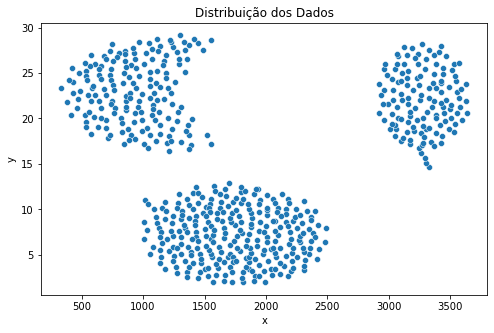

In [51]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.scatterplot(data=data_1, x="x", y="y")
plt.title('Distribuição dos Dados')
plt.show()


## U.S. News and World Report’s College Data

Esse dataset é formado por estatísticas de um grande número de faculdades dos EUA, da edição de 1995 do "US News and World Report". Este conjunto de dados foi retirado da biblioteca StatLib, que é mantida na Carnegie Mellon University e foi disponibilizado pela plataforma Kaggle. (https://www.kaggle.com/flyingwombat/us-news-and-world-reports-college-data).

O problema busca identificar se as faculdades são públicas ou privadas através das features.

In [52]:
data_2 = pd.read_csv('College.csv')

In [53]:
print('Tamanho do dataset: {}'.format(data_2.shape))

Tamanho do dataset: (777, 19)


In [54]:
data_2.head()

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


Significado de cada feature:

    - Private: Não e Sim indicando universidade pública ou privada;
    - Apps: Número de aplicações recebidas;
    - Accept: Número de aplicações aceitas;
    - Enroll: Número de novos alunos matriculados;
    - Top10perc: Percentil dos novos alunos - 10% melhores do H.S. aula;
    - Top25perc: Percentil dos novos alunos - 25% melhores do H.S. aula;
    - F.Undergrad: Número de alunos de graduação em tempo integral; 
    - P.Undergrad: Número de alunos de graduação em meio período;
    - Outstate: Taxas externas do estado; 
    - Room.Board: Moradia e custos de alimentação;
    - Books: Custo estimado de livros; 
    - Personal: Custo pessoal estimado; 
    - PhD: Percentual do corpo docente com Ph.D.;
    - Terminal: Percentual do corpo docente com grau terminal; 
    - S.F.Ratio: Razão aluno/professor; 
    - perc.alumni: Percentual de ex-alunos que doam; 
    - Expend: Gastos com instrução por aluno;        
    - Grad.Rate: Taxa de graduação.
    
O private é o label do dataset portanto para não haver vazamento de dados, vamos retirá-lo do dataset, de mesma forma do 'Unnamed: 0' que se trata de qual faculdade estamos tratando.

In [55]:
data_2 = data_2.drop(columns=['Unnamed: 0', 'Private'])

Tipo de dados de cada feature e verificação de dados nulos:

In [56]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Apps         777 non-null    int64  
 1   Accept       777 non-null    int64  
 2   Enroll       777 non-null    int64  
 3   Top10perc    777 non-null    int64  
 4   Top25perc    777 non-null    int64  
 5   F.Undergrad  777 non-null    int64  
 6   P.Undergrad  777 non-null    int64  
 7   Outstate     777 non-null    int64  
 8   Room.Board   777 non-null    int64  
 9   Books        777 non-null    int64  
 10  Personal     777 non-null    int64  
 11  PhD          777 non-null    int64  
 12  Terminal     777 non-null    int64  
 13  S.F.Ratio    777 non-null    float64
 14  perc.alumni  777 non-null    int64  
 15  Expend       777 non-null    int64  
 16  Grad.Rate    777 non-null    int64  
dtypes: float64(1), int64(16)
memory usage: 103.3 KB


### Outliers

Pela verificação de outliers utilizando o método 1.5 IQR. Para a detecção definimos um intervalo de decisão:

- Limite inferior: (Q1 - 1,5 * IQR)
- Limite superior: (Q3 + 1,5 * IQR)

IQR significa intervalo interquartil, que pode ser calculado através de:

IQR = Q3(Quartil 75%) - Q1(Quartil 25%)

In [57]:
def remove_outlier(df_in, col_names):

    q1 = df_in[col_names[0]].quantile(0.25)
    q3 = df_in[col_names[0]].quantile(0.75)
    iqr = q3 - q1
    fence_low  = q1 - 1.5*iqr
    fence_high = q3 + 1.5*iqr
    
    LogicalKeeper = (df_in[col_names[0]] >= fence_low) & (df_in[col_names[0]] <= fence_high)
    
    for col_name in col_names[1:]:
        q1 = df_in[col_name].quantile(0.25)
        q3 = df_in[col_name].quantile(0.75)
        iqr = q3 - q1 
        fence_low  = q1 - 1.5*iqr
        fence_high = q3 + 1.5*iqr
        LogicalKeeper = LogicalKeeper & ((df_in[col_name] >= fence_low) & (df_in[col_name] <= fence_high))
        
    return df_in[LogicalKeeper].reset_index(drop = True)

In [58]:
data_2 = remove_outlier(data_2, data_2.columns.tolist())
data_1 = remove_outlier(data_1, data_1.columns.tolist())

In [59]:
print(len(data_2))

539


# Parte 2: Métodos de Clusterização

### K-Means

In [60]:
class K_means:
    # num_centroids: número de centroids escolhido
    # dados: conjunto de dados que sera utilizado
    # num_iter: número de iterações que devemos submeter o conjunto de dados
    def __init__(self, num_centroids, dados, num_iter, init_type="notrandom"):
        self.num_centroids = num_centroids
        self.dados = dados
        self.num_iter = num_iter
        self.cluster_labels = []
        self.cluster_centroids = []
        self.predicted_cluster_labels = []
        self.init_type = init_type.lower()
    
    def calc_distance(self, x, y):
        return dist.euclidean(x,y)
    
    def initRandom(self):
        init_centroids = random.sample(range(0, len(self.dados)), self.num_centroids)
        centroids = []
        for i in init_centroids:
            centroids.append(self.dados.loc[i])
        centroids = np.array(centroids)
        return centroids
    
    def initPlus(self):
        dataArray = np.array(self.dados)
        # Seleciona o centro do primeiro cluster
        init_centroids = []
        init_centroids.append((random.sample(range(0, len(self.dados)), 1))[0])
        
        centroids = []
        for i in init_centroids:
            centroids.append(self.dados.loc[i])

        ## Computa os centros restantes
        for c_id in range(self.num_centroids - 1):
            
            dist = []
            for i in range(len(self.dados)):
                point = dataArray[i]
                d = sys.maxsize
                
                # calcula a distancia do ponto atual com os centros e armazena a menor distancia
                for j in range(len(centroids)):
                    temp_dist = self.calc_distance(point, centroids[j])
                    d = min(d, temp_dist)
                dist.append(d)

            ## seleciona o ponto que tem a maior distancia dos outros centros para ser um novo centro de cluster
            dist = np.array(dist)
            next_centroid = dataArray[np.argmax(dist), :]
            centroids.append(next_centroid)
            dist = []

        return np.array(centroids)
        

    def findClosestCentroids(self, ic, X):
        assigned_centroids = []
        for i in X:
            distance = []
            for j in ic:
                distance.append(self.calc_distance(i,j))
            assigned_centroids.append(np.argmin(distance))
        return assigned_centroids


    def calc_centroids(self, clusters, X):
        new_centroids = []
        new_df = pd.concat([pd.DataFrame(X), pd.DataFrame(clusters, columns=['cluster'])],
                        axis=1)
        for c in set(new_df['cluster']):
            current_cluster = new_df[new_df['cluster'] == c][new_df.columns[:-1]]
            cluster_mean = current_cluster.mean(axis=0)
            new_centroids.append(cluster_mean)
        return new_centroids
    
    def runKmeans(self):
        dataArray = np.array(self.dados)
        
        # Recupera o valor de cada um dos índices de centroids escolhidos
        if(self.init_type == "random"):
            print("entrou random")
            centroids = self.initRandom()
        else:
            centroids = self.initPlus()
            
        for i in range(self.num_iter):
            get_centroids = self.findClosestCentroids(centroids, dataArray)
            centroids = self.calc_centroids(get_centroids, dataArray)
            
            self.cluster_labels.append(get_centroids)
            self.cluster_centroids.append(centroids)
    ### TEM QUE MUDAR MANUALMENTE AS FUNÇÕES DE PLOT PARA NÚMERO DE CLUSTERS DIFERENTES
    
    def plotKmeans(self):
        dataArray = np.array(self.dados)
        for i in range(self.num_iter):
            ## DataFrame precisa ser criado manualmente de acordo com o dataset
            datatest = pd.DataFrame({'Column1': dataArray[:, 0], 'Column2': dataArray[:, 1], 'Column3': dataArray[:, 2], 'Column4': dataArray[:, 3], 'Cluster': self.cluster_labels[i]})
            groups = datatest.groupby("Cluster")
            plt.figure()
            for name, group in groups:
                plt.plot(group["Column1"], group["Column2"], marker="o", linestyle="", label=name, zorder=1) 
            plt.scatter(np.array(self.cluster_centroids[i])[:, 0], np.array(self.cluster_centroids[i])[:, 1], color=['black','green','red'], marker="*",zorder=2, s=100)
            
    ### TEM QUE MUDAR MANUALMENTE AS FUNÇÕES DE PLOT PARA NÚMERO DE CLUSTERS DIFERENTES
    def plotPredict(self, test_dataset):
        dataArray = np.array(test_dataset)
        ## DataFrame precisa ser criado manualmente de acordo com o dataset
        datatest = pd.DataFrame({'Column1': dataArray[:, 0], 'Column2': dataArray[:, 1], 'Column3': dataArray[:, 2], 'Column4': dataArray[:, 3], 'Cluster': self.predicted_cluster_labels})
        groups = datatest.groupby("Cluster")

        plt.figure()
        for name, group in groups:
            plt.plot(group["Column1"], group["Column2"], marker="o", linestyle="", label=name, zorder=1)
        plt.scatter(np.array(self.cluster_centroids[self.num_iter - 1])[:, 0], np.array(self.cluster_centroids[self.num_iter - 1])[:, 1], color=['black','green', 'red'], marker="*",zorder=2, s=100)
        
    def listaTodasDistanciaCentro(self):
        dataArray = np.array(self.dados)
        distancias = []
        
        for i in range(len(dataArray)):
            index = np.array(self.cluster_labels[self.num_iter - 1])[i]
            vetor = np.array(self.cluster_centroids[self.num_iter - 1])
            distancias.append(self.calc_distance(dataArray[i], vetor[index, :]))
        return distancias
    
    def predict(self, data):
        return np.argmin(euclidean_distances(np.array(data), np.array(self.cluster_centroids[-1])), axis =1)

### MeanShift

Diferentemente do K-means que nós colocamos o número de clusters pretendido, no meanshift a gente quer que o algoritmo descubra a quantidade de clusters.

In [61]:
class Mean_Shift:
    def __init__(self, radius):
        '''Raio do centróide'''
        self.radius = radius
        self.cluster_centroids = {}
        
        
    def euclidean_distance(x, centroid):
        '''Cálculo da distância euclidiana de n-dimensões'''
        return np.sqrt(np.sum((x - centroid)**2))

    def fit(self, data):
        '''A função primeiro faz todos os dados virarem centróides, em seguida calcula a média dos 
        pontos dentro do raio do centróide gerando um novo centróide e repete até convergir.
        O algoritmo fica responsável pela escolha da quantidade de clusters'''
        data = np.array(data)
        centroids = {}

        for i in range(len(data)):
            centroids[i] = data[i]
        
        while True:
            new_centroids = []
            for i in centroids:
                in_bandwidth = []
                centroid = centroids[i]
                for points in data:
                    if np.linalg.norm(points-centroid) < self.radius:
                        in_bandwidth.append(points)

                new_centroid = np.average(in_bandwidth,axis=0)
                new_centroids.append(tuple(new_centroid))

            uniques = sorted(list(set(new_centroids)))

            prev_centroids = dict(centroids)

            centroids = {}
            for i in range(len(uniques)):
                centroids[i] = np.array(uniques[i])

            optimized = True

            for i in centroids:
                if not np.array_equal(centroids[i], prev_centroids[i]):
                    optimized = False
                if not optimized:
                    break
                
            if optimized:
                break

        self.cluster_centroids = centroids
    
    def get_series_centroid(self):
         return [pd.Series(self.cluster_centroids[i]) for i in self.cluster_centroids]
        
    def predict(self, data):
        return np.argmin(euclidean_distances(np.array(data), np.array(list(self.cluster_centroids.values()))), axis =1)

    def cost(self, data, centroid):
        '''A função calcula o custo de distância dos clusters próximos'''
       
        data = np.array(data)
        total_distance = []

        for i in range(len(data)): 
            aux_distance = []
            
            for j in centroid.keys():
                aux_distance.append(dist.euclidean(data[i], centroid[j]))
            
            total_distance.append(aux_distance)
        
        total_distance = np.array(total_distance)
        min_distance_data_centr = np.min(total_distance, axis = 1)

        cost = np.array(np.sum(min_distance_data_centr)/(2*len(min_distance_data_centr)))
        
        return cost.item()

### Divisão dos dados entre Treino e Teste (90/10)

In [62]:
def train_test_split(x, train_per = 0.9, test_per = 0.1,shuffle = True):
    
    n_samples = len(x)
    n_train, n_test = round(train_per*n_samples), round(test_per*n_samples)
    
    if shuffle:
        x_teste = x.reindex(np.random.permutation(x.index))
        train = x_teste.iloc[:n_train]
        test = x_teste.iloc[n_train:n_test+n_train]
    else:
        train = x.iloc[:n_train]
        test = x.iloc[n_train:n_test+n_train]
        
    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)
        
    return train, test

train_1, test_1 = train_test_split(data_1)
train_2, test_2 = train_test_split(data_2)

In [63]:
print('Tamanho inicial: {} - Treino: {}, Teste: {}'.format(data_1.shape, train_1.shape, test_1.shape))
print('Tamanho inicial: {} - Treino: {}, Teste: {}'.format(data_2.shape, train_2.shape, test_2.shape))

Tamanho inicial: (573, 2) - Treino: (516, 2), Teste: (57, 2)
Tamanho inicial: (539, 17) - Treino: (485, 17), Teste: (54, 17)


### Normalização
Como a escala dos dados é parecida, optamos pela normalização dos dados para ajudar o algoritmo.

In [64]:
class Normalization:
    def __init__(self, x_data, min_x = [], max_x = []):
        self.x_data = x_data.copy(deep=True)
        self.min = min_x
        self.max = max_x
        
    def fit(self):
        self.min = [min(self.x_data[i]) for i in self.x_data.columns]
        self.max = [max(self.x_data[i]) for i in self.x_data.columns]
        
    def normalization(self, x, min_x, max_x):
        return (x - min_x) / (max_x - min_x) 
    
    def transform(self, X):
        data = X.copy(deep=True)
        for i in range(len(self.x_data.columns)):
            col = self.x_data.columns[i]
            data[col] = data[col].apply(lambda x: self.normalization(x, self.min[i], self.max[i]))
            
        return data
        

Normalizamos a base de teste, de acordo com os valores da base de treino, para não haver vazamento de dados.

In [65]:
data_1_norm = Normalization(train_1)
data_2_norm = Normalization(train_2)

data_1_norm.fit()
data_2_norm.fit()

train_1_norm = data_1_norm.transform(train_1)
test_1_norm = data_1_norm.transform(test_1)

train_2_norm = data_2_norm.transform(train_2)
test_2_norm = data_2_norm.transform(test_2)

# Verificando o melhores parâmetros

Aplicação do método Elbow para verificação das melhores configurações de quantidade de clusters no caso do K-Means, e o melhor tamanho de raio no caso do Mean Shift.

## K-Means

In [66]:
def elbow_curve_kmeans(k, data, iterations):
    custo_total = []
    
    for i in k:
        kmeans = K_means(i, data, iterations)
        kmeans.runKmeans()
        distancias = kmeans.listaTodasDistanciaCentro()
        custo = np.array(sum(distancias)/(2*len(data)))
        custo = custo.item()
        custo_total.append(custo)
        
    return custo_total

k = np.array(range(1,11))

        
train_1_norm_cost = elbow_curve_kmeans(k, train_1_norm, 20)
train_1_cost = elbow_curve_kmeans(k, train_1, 20)

train_2_norm_cost = elbow_curve_kmeans(k, train_2_norm, 20)
train_2_cost = elbow_curve_kmeans(k, train_2, 20)


In [67]:
def plot_elbow(k, data, data_norm, title, x_label):
    plt.figure(figsize=(15,3))
    
    plt.subplot(1,2,1)
    plt.plot(k, data)
    plt.xlabel(x_label)
    plt.ylabel("Dispersion")
    plt.title(title[0])
    
    plt.subplot(1,2,2)
    plt.plot(k, data_norm)
    plt.xlabel(x_label)
    plt.ylabel("Dispersion")
    plt.title(title[1])
    
    plt.show()



Pelo método do Elbow curve, para o dataset 1 a melhor configuração é dado pelo k = 3, visto que a partir dessa quantidade de clusters não tem melhora significativa na curva.

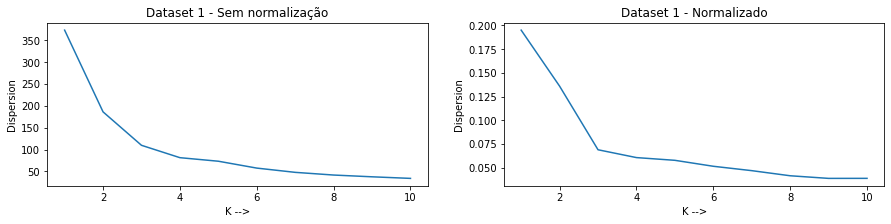

In [68]:
plot_elbow(k, train_1_cost, train_1_norm_cost, ['Dataset 1 - Sem normalização', 'Dataset 1 - Normalizado'], "K -->")

Pelo método do Elbow Curve podemos analisar que a melhor configuração para o dataset 2 é o k = 5 visto que, depois desse número de clusters a curva não tem melhora significativa.

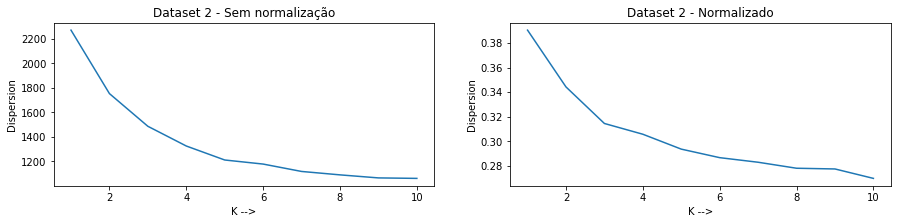

In [69]:
plot_elbow(k, train_2_cost, train_2_norm_cost, ['Dataset 2 - Sem normalização', 'Dataset 2 - Normalizado'], "K -->")

## MeanShift

Como o MeanShift não tem como parâmetro a quantidade de clusters mas sim o raio, fizemos uma adaptação do elbow curve verificando a dispersão conforme aumentamos o raio.

In [27]:
radius = np.linspace(2, 0.1, 20)

def elbow_curve_meanshift(radius, data):
    custo_total = []
    
    for i in radius:
        clf = Mean_Shift(radius = i)
        clf.fit(data)
        centroids = clf.cluster_centroids
        custo_total.append(clf.cost(data, centroids))
    
    return custo_total



train_1_norm_cost = elbow_curve_meanshift(radius, train_1_norm)
train_1_cost = elbow_curve_meanshift(radius, train_1)

train_2_norm_cost = elbow_curve_meanshift(radius, train_2_norm)
train_2_cost = elbow_curve_meanshift(radius, train_2)



Pela adaptação do método Elbow Curve podemos analisar que a melhor configuração para o dataset 1 é o raio = 0.35 visto que, depois desse número de clusters a curva não tem melhora significativa.

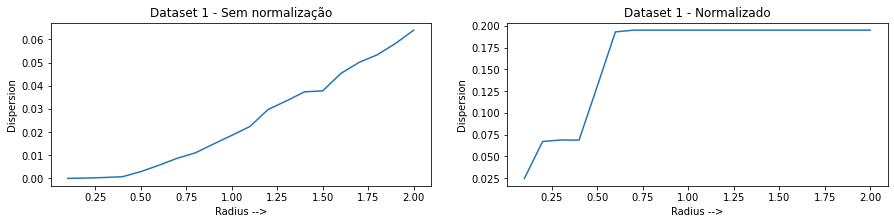

In [28]:
plot_elbow(radius, train_1_cost, train_1_norm_cost, ['Dataset 1 - Sem normalização', 'Dataset 1 - Normalizado'],'Radius -->')


Pela adaptação do método Elbow Curve podemos analisar que a melhor configuração para o dataset 2 é o raio = 0.87 visto que, depois desse número de clusters a curva não tem melhora significativa.

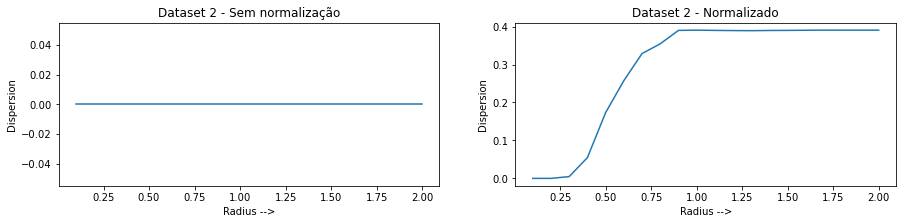

In [29]:
plot_elbow(radius, train_2_cost, train_2_norm_cost, ['Dataset 2 - Sem normalização', 'Dataset 2 - Normalizado'],'Radius -->')


# Métricas de Avaliação



##  Xie Beni

Define a separação inter-clusters como o mínimo do quadrado entre as distâncias entre os clusters, por outro lado, define como intra-clusters como a média do quadrado das distâncias entre o dado e seu cluster.
Função de minimização, quanto menor o valor, melhor.

In [70]:
from sklearn.metrics.pairwise import euclidean_distances

def inter_cluster(centroids):
    centr = np.array(centroids)

    tri_dists = euclidean_distances(centr, centr)[np.triu_indices(len(centroids), 1)]

    InterClusterDistance = 0

    for i in range(len(tri_dists)):
        InterClusterDistance += tri_dists[i]**2
        
    return InterClusterDistance
    
def intra_cluster(data, pred, centroids):
    distance_min = np.min(euclidean_distances(np.array(data), np.array(centroids)), axis =1)
    
    intra_clusters_distances = dict()
    
    for i in range(len(centroids)):
        intra_clusters_distances[i] = 0
        
    for i in range(len(distance_min)):
        intra_clusters_distances[pred[i]] += distance_min[i]**2
    
    return intra_clusters_distances

def xie_beni(data, pred, centroids):
    
    inter_ = inter_cluster(centroids)
    intra_ = np.sum(list(intra_cluster(data, pred, centroids).values()))
    
    return intra_/inter_

## Davies-Bouldin

Mede a similaridade dos clusters considerando a dispersão dos clusters e a separação entre eles. Função de minimização, quanto menor melhor.

In [71]:
def davies_bouldin_score(X, labels):
    X = np.array(X)
    n_labels = len(np.unique(labels))
    intra_dists = np.zeros(n_labels)
    centroids = np.zeros((n_labels, len(X[0])), dtype=float)
    
    df = pd.DataFrame(X)
    df['label'] = labels
    
    for k in range(n_labels):
        cluster_k = np.array(df[df['label'] == k].drop(['label'], axis = 1))
        centroid = cluster_k.mean(axis=0)
        centroids[k] = centroid
        intra_dists[k] = np.average(pairwise_distances(cluster_k, [centroid]))
    centroid_distances = pairwise_distances(centroids)

    if np.allclose(intra_dists, 0) or np.allclose(centroid_distances, 0):
        return 0.0
    centroid_distances[centroid_distances == 0] = np.inf
    combined_intra_dists = intra_dists[:, None] + intra_dists
    scores = np.max(combined_intra_dists / centroid_distances, axis=1)
    return np.mean(scores)

## Dunn

Este método minimiza a separação inter-cluster e maximiza a compacidade intra-cluster. Função de maximização, quanto maior melhor.


In [72]:
def diameter(labels, distances, method='farthest'):
    if method not in ['mean_cluster', 'farthest']:
        raise ValueError('method must be one of {}'.format(['mean_cluster', 'farthest']))

    n_clusters = len(np.unique(labels))
    diameters = np.zeros(n_clusters)

    if method == 'mean_cluster':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii]:
                    diameters[labels[i]] += distances[i, ii]

        for i in range(len(diameters)):
            diameters[i] /= sum(labels == i)

    elif method == 'farthest':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii] and distances[i, ii] > diameters[
                        labels[i]]:
                    diameters[labels[i]] = distances[i, ii]
    return diameters


def dunn(labels, X, diameter_method='farthest', cdist_method='nearest'):
    
    distances = euclidean_distances(X, X)
    
    ic_distances = inter_cluster_distances(labels, distances, cdist_method)
    min_distance = min(ic_distances[ic_distances.nonzero()])
    max_diameter = max(diameter(labels, distances, diameter_method))

    return min_distance / max_diameter

def inter_cluster_distances(labels, distances, method='nearest'):
    if method not in ['nearest', 'farthest']:
        raise ValueError(
            'method must be one of {}'.format(['nearest', 'farthest']))

    if method == 'nearest':
        return __cluster_distances_by_points(labels, distances)
    elif method == 'farthest':
        return __cluster_distances_by_points(labels, distances, farthest=True)

    
def __cluster_distances_by_points(labels, distances, farthest=False):
    n_unique_labels = len(np.unique(labels))
    cluster_distances = np.full((n_unique_labels, n_unique_labels),
                                float('inf') if not farthest else 0)

    np.fill_diagonal(cluster_distances, 0)

    for i in np.arange(0, len(labels) - 1):
        for ii in np.arange(i, len(labels)):
            if labels[i] != labels[ii] and (
                (not farthest and
                 distances[i, ii] < cluster_distances[labels[i], labels[ii]])
                    or
                (farthest and
                 distances[i, ii] > cluster_distances[labels[i], labels[ii]])):
                cluster_distances[labels[i], labels[ii]] = cluster_distances[
                    labels[ii], labels[i]] = distances[i, ii]
    return cluster_distances

## Testes - Melhores configurações dos modelos

In [73]:
clusters_metrics = pd.DataFrame(columns=['method', 'norm', 'dataset', 'train', 'dunn', 'davies_bouldin', 'xie_beni'])

In [74]:
def metrics(data, predict, centroids, method, norm, dataset, train):
    
    dunn_variable = dunn(predict, data)
    db = davies_bouldin_score(np.array(data), np.array(predict))
    xie = xie_beni(np.array(data), np.array(predict), np.array(centroids))

    return {'method': method, 'dunn': dunn_variable, 'davies_bouldin': db, 'xie_beni': xie, 'norm': norm, 'dataset': dataset, 'train': train}


### K-Means

In [75]:
# Train dataset 1 sem normalização
kmeans_1 = K_means(3, train_1, 20)
kmeans_1.runKmeans()


# Train dataset 1 com normalização
kmeans_1_norm = K_means(3, train_1_norm, 20)
kmeans_1_norm.runKmeans()

# Train dataset 2 sem normalização
kmeans_2 = K_means(3, train_2, 35)
kmeans_2.runKmeans()

# Train dataset 2 com normalização
kmeans_2_norm = K_means(3, train_2_norm, 35)
kmeans_2_norm.runKmeans()

In [85]:
def plot_train_test_pred(data_1, data_2, pred1, pred2, centroids):
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    sns.scatterplot(data=data_1, x="x", y="y", hue=pred1, palette="deep")
    for c in range(len(centroids)): 
        plt.scatter(centroids[c][0], centroids[c][1], color='r', marker='*', s=150)

    plt.subplot(1,2,2) 
    sns.scatterplot(data=data_2, x="x", y="y", hue=pred2, palette="deep") 
    for c in range(len(centroids)): 
        plt.scatter(centroids[c][0], centroids[c][1], color='r', marker='*', s=150)

### K-Means dataset 1 

### Sem normalização

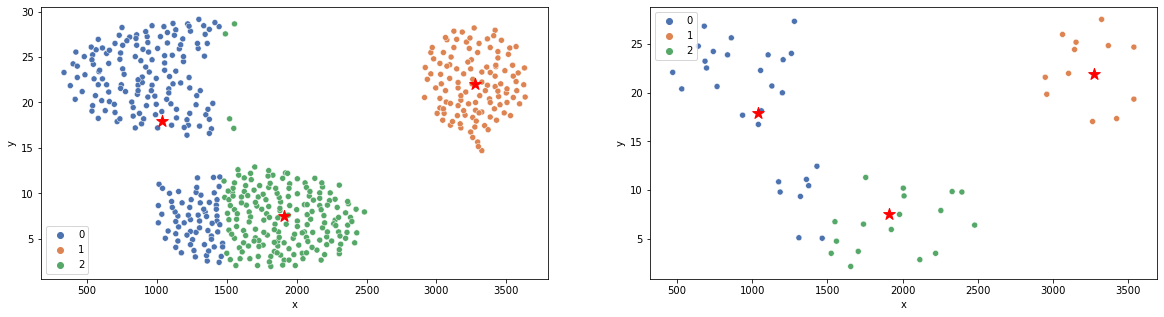

In [86]:
pred1_train = kmeans_1.predict(train_1)
pred1_test = kmeans_1.predict(test_1)

plot_train_test_pred(train_1, test_1, pred1_train, pred1_test, kmeans_1.cluster_centroids[-1])

### Com normalização

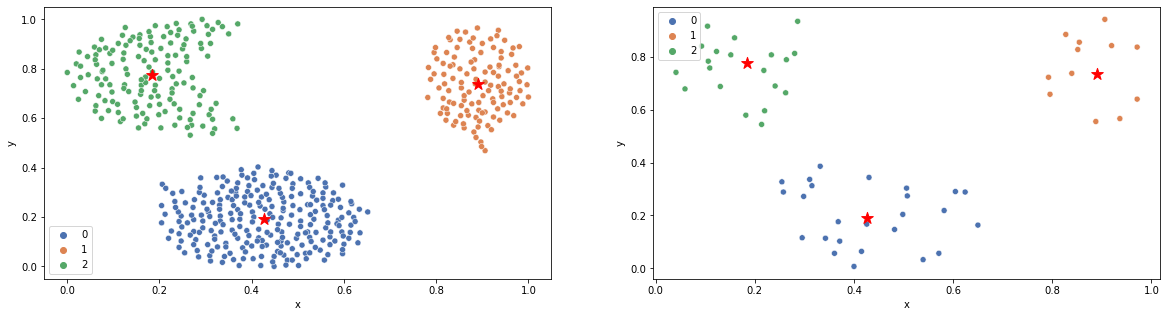

In [89]:
pred1_train = kmeans_1_norm.predict(train_1_norm)
pred1_test = kmeans_1_norm.predict(test_1_norm)

plot_train_test_pred(train_1_norm, test_1_norm, pred1_train, pred1_test, kmeans_1_norm.cluster_centroids[-1])

In [ ]:
clusters_metrics = clusters_metrics.append(metrics(train_1, kmeans_1.predict(train_1), kmeans_1.cluster_centroids[-1], 'kmeans', 0 , 1, 1), ignore_index=True)
clusters_metrics = clusters_metrics.append(metrics(train_1_norm, kmeans_1_norm.predict(train_1_norm), kmeans_1_norm.cluster_centroids[-1], 'kmeans',1,1,1), ignore_index=True)

## Dataset 2 

Dimensão impossibilita plot, entretanto as métricas estão sendo aplicadas para o dataset normalizado e sem normalização.

In [36]:
clusters_metrics = clusters_metrics.append(metrics(train_2, kmeans_2.predict(train_2), kmeans_2.cluster_centroids[-1], 'kmeans',0,2,1), ignore_index=True)
clusters_metrics = clusters_metrics.append(metrics(train_2_norm, kmeans_2_norm.predict(train_2_norm),  kmeans_2_norm.cluster_centroids[-1], 'kmeans',1,2,1), ignore_index=True)

### Mean Shift

In [92]:
# Train dataset 1 sem normalização
means_1 = Mean_Shift(radius = 0.3)
means_1.fit(train_1)

# Train dataset 1 com normalização
means_1_norm = Mean_Shift(radius = 0.3)
means_1_norm.fit(train_1_norm)

# Train dataset 2 sem normalização
means_2 = Mean_Shift(radius = 0.3)
means_2.fit(train_2)

# Train dataset 2 com normalização
means_2_norm = Mean_Shift(radius = 0.3)
means_2_norm.fit(train_2_norm)

## Dataset 1 

#### Sem normalização

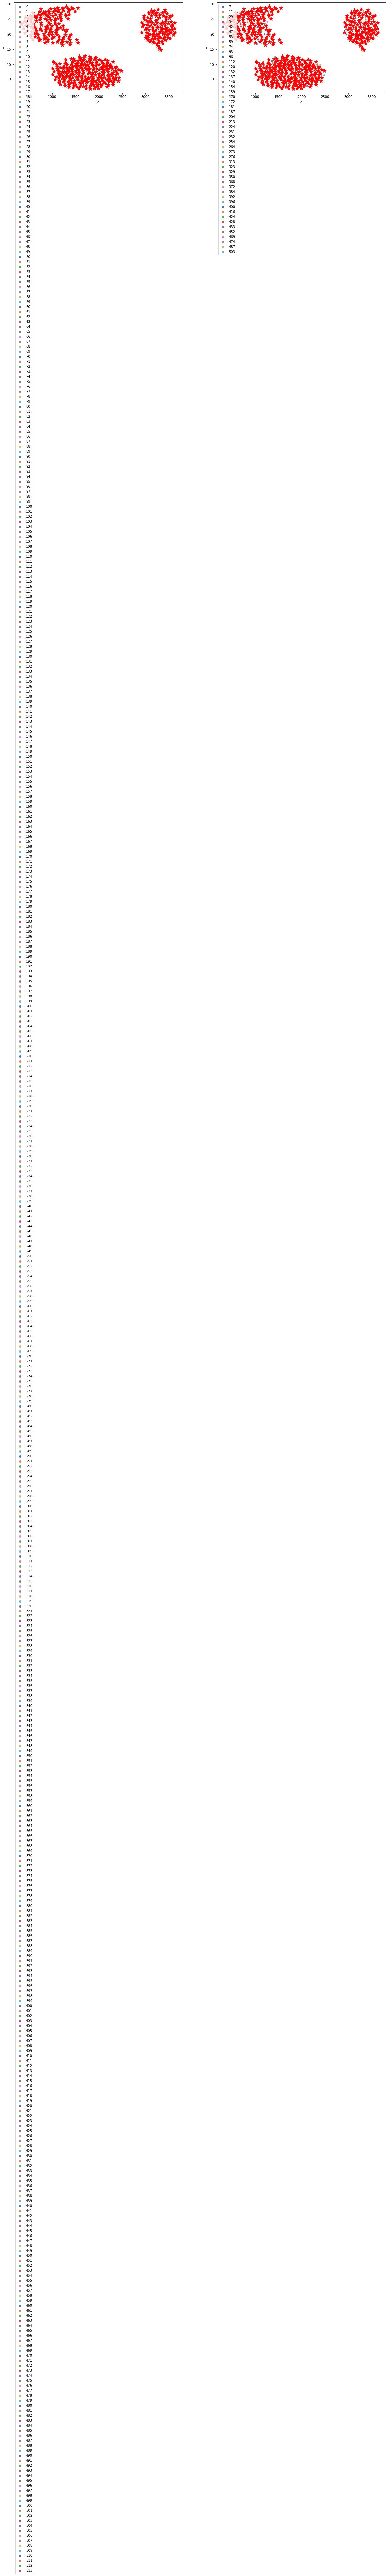

In [94]:
pred1_train = means_1.predict(train_1)
pred1_test = means_1.predict(test_1)

plot_train_test_pred(train_1, test_1, pred1_train, pred1_test, np.array(list(means_1.get_series_centroid())))

#### Com normalização

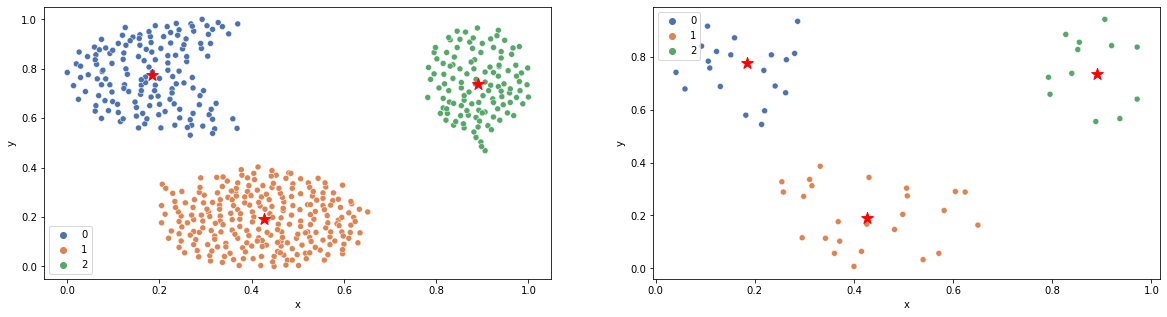

In [95]:
pred1_train = means_1_norm.predict(train_1_norm)
pred1_test = means_1_norm.predict(test_1_norm)

plot_train_test_pred(train_1_norm, test_1_norm, pred1_train, pred1_test, np.array(list(means_1_norm.get_series_centroid())))

In [40]:
clusters_metrics = clusters_metrics.append(metrics(train_1, means_1.predict(train_1), np.array(list(means_1.get_series_centroid())), 'meanshift',0,1,1), ignore_index=True)
clusters_metrics = clusters_metrics.append(metrics(train_1_norm, means_1_norm.predict(train_1_norm), np.array(list(means_1_norm.cluster_centroids.values())), 'meanshift',1,1,1), ignore_index=True)

clusters_metrics = clusters_metrics.append(metrics(train_2, means_2.predict(train_2), np.array(list(means_2.get_series_centroid())), 'meanshift',0,2,1), ignore_index=True)
clusters_metrics = clusters_metrics.append(metrics(train_2_norm, means_2_norm.predict(train_2_norm), np.array(list(means_2_norm.cluster_centroids.values())), 'meanshift',1,2,1), ignore_index=True)


<ipython-input-32-008c732f2e68>:34: RuntimeWarning: divide by zero encountered in double_scalars
  return min_distance / max_diameter


# PCA

In [100]:
from sklearn.decomposition import PCA

pca_1 = PCA(n_components=1)
pca_2 = PCA(n_components=2)
pca_3 = PCA(n_components=3)

train_2_3d = pca_3.fit_transform(train_2.copy(deep=True))
train_2_2d = pca_2.fit_transform(train_2.copy(deep=True))
train_2_1d = pca_1.fit_transform(train_2.copy(deep=True))

test_2_3d = pca_3.fit_transform(test_2.copy(deep=True))
test_2_2d = pca_2.fit_transform(test_2.copy(deep=True))
test_2_1d = pca_1.fit_transform(test_2.copy(deep=True))

train_2_3d_norm = pca_3.fit_transform(train_2_norm.copy(deep=True))
train_2_2d_norm = pca_2.fit_transform(train_2_norm.copy(deep=True))
train_2_1d_norm = pca_1.fit_transform(train_2_norm.copy(deep=True))

test_2_3d_norm = pca_3.fit_transform(test_2_norm.copy(deep=True))
test_2_2d_norm = pca_2.fit_transform(test_2_norm.copy(deep=True))
test_2_1d_norm = pca_1.fit_transform(test_2_norm.copy(deep=True))

----------------------------------------------------------------------------------------------------------------
### Kmeans com k =3

#### 3 Dimensões 

##### Não normalizado

In [124]:
kmeans_2_3d = K_means(3, pd.DataFrame(train_2_3d), 20)
kmeans_2_3d.runKmeans()

pred_train_2 = kmeans_2_3d.predict(train_2_3d)
pred_test_2 = kmeans_2_3d.predict(test_2_3d)


##### Normalizado

In [125]:
kmeans_2_3d_norm = K_means(3, pd.DataFrame(train_2_3d_norm), 20)
kmeans_2_3d_norm.runKmeans()

pred_train_2 = kmeans_2_3d_norm.predict(train_2_3d_norm)
pred_test_2 = kmeans_2_3d_norm.predict(test_2_3d_norm)

#### 2 Dimensões 

##### Não Normalizado

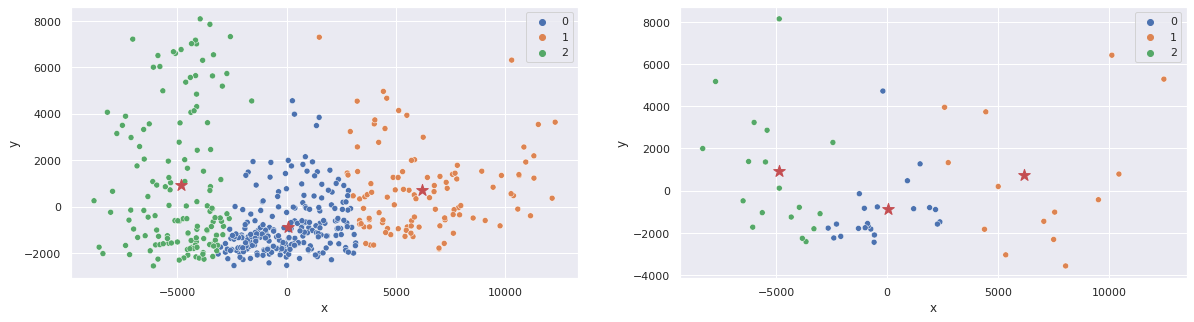

In [116]:
kmeans_2_2d = K_means(3, pd.DataFrame(train_2_2d), 20)
kmeans_2_2d.runKmeans()

pred_train_2 = kmeans_2_2d.predict(train_2_2d)
pred_test_2 = kmeans_2_2d.predict(test_2_2d)

plot_train_test_pred(pd.DataFrame(train_2_2d, columns=["x", "y"]), pd.DataFrame(test_2_2d, columns=["x", "y"]), pred_train_2, pred_test_2, kmeans_2_2d.cluster_centroids[-1])

##### Normalizado

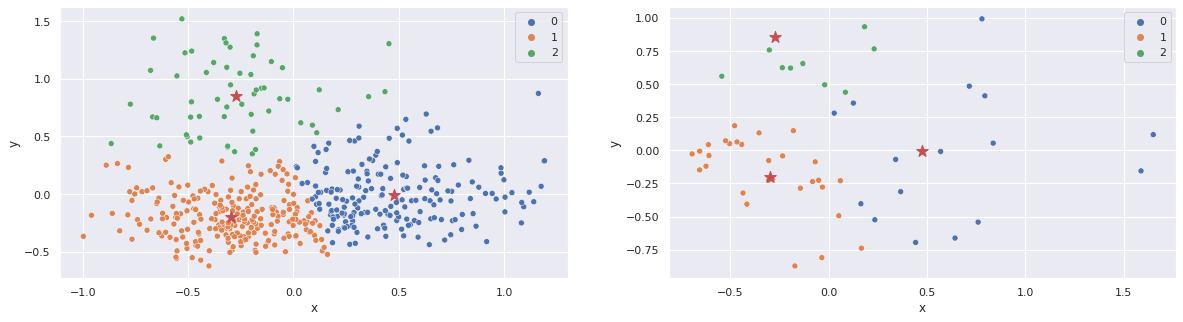

In [121]:
kmeans_2_2d_norm = K_means(3, pd.DataFrame(train_2_2d_norm), 20)
kmeans_2_2d_norm.runKmeans()

pred_train_2 = kmeans_2_2d_norm.predict(train_2_2d_norm)
pred_test_2 = kmeans_2_2d_norm.predict(test_2_2d_norm)

plot_train_test_pred(pd.DataFrame(train_2_2d_norm, columns=["x", "y"]), pd.DataFrame(test_2_2d_norm, columns=["x", "y"]), pred_train_2, pred_test_2, kmeans_2_2d_norm.cluster_centroids[-1])

#### 1 Dimensão

##### Não normalizado

In [120]:
kmeans_2_1d = K_means(3, pd.DataFrame(train_2_1d), 20)
kmeans_2_1d.runKmeans()

pred_train_2 = kmeans_2_1d.predict(train_2_1d)
pred_test_2 = kmeans_2_1d.predict(test_2_1d)



##### Normalizado

In [123]:
kmeans_2_1d_norm = K_means(3, pd.DataFrame(train_2_1d_norm), 20)
kmeans_2_1d_norm.runKmeans()

pred_train_2 = kmeans_2_1d_norm.predict(train_2_1d_norm)
pred_test_2 = kmeans_2_1d_norm.predict(test_2_1d_norm)

#### Métricas de avaliação dos clusters - k=3, dimensões: [3,2,1], normalizado e não normalizado

In [ ]:
clusters_metrics = clusters_metrics.append(metrics(pd.DataFrame(train_2_3d), kmeans_2_3d.predict(pd.DataFrame(train_2_3d)), kmeans_2_3d.cluster_centroids[-1], 'kmeans-3d', 0 , 2, 1), ignore_index=True)
clusters_metrics = clusters_metrics.append(metrics(train_2_2d, kmeans_2_2d.predict(train_2_2d), kmeans_2_2d.cluster_centroids[-1], 'kmeans-2d',0,2,1), ignore_index=True)
clusters_metrics = clusters_metrics.append(metrics(train_2_1d, kmeans_2_1d.predict(train_2_1d), kmeans_2_1d.cluster_centroids[-1], 'kmeans-1d',0,2,1), ignore_index=True)
clusters_metrics = clusters_metrics.append(metrics(pd.DataFrame(train_2_3d_norm), kmeans_2_3d_norm.predict(pd.DataFrame(train_2_3d_norm)), kmeans_2_3d_norm.cluster_centroids[-1], 'kmeans-3d', 1, 2, 1), ignore_index=True)
clusters_metrics = clusters_metrics.append(metrics(train_2_2d_norm, kmeans_2_2d_norm.predict(train_2_2d_norm), kmeans_2_2d_norm.cluster_centroids[-1], 'kmeans-2d',1,2,1), ignore_index=True)
clusters_metrics = clusters_metrics.append(metrics(train_2_1d_norm, kmeans_2_1d_norm.predict(train_2_1d_norm), kmeans_2_1d_norm.cluster_centroids[-1], 'kmeans-1d',1,2,1), ignore_index=True)


--------------------------------------------------------------------------------------------------------------

### Kmeans com k=4

#### 3 Dimensões 

#### Não normalizado

In [ ]:
kmeans_2_3d = K_means(4, pd.DataFrame(train_2_3d), 20)
kmeans_2_3d.runKmeans()

pred_train_2 = kmeans_2_3d.predict(train_2_3d)
pred_test_2 = kmeans_2_3d.predict(test_2_3d)

##### Normalizado

In [126]:
kmeans_2_3d_norm = K_means(4, pd.DataFrame(train_2_3d_norm), 20)
kmeans_2_3d_norm.runKmeans()

pred_train_2 = kmeans_2_3d_norm.predict(train_2_3d_norm)
pred_test_2 = kmeans_2_3d_norm.predict(test_2_3d_norm)

#### 2 Dimensões

##### Não normalizado

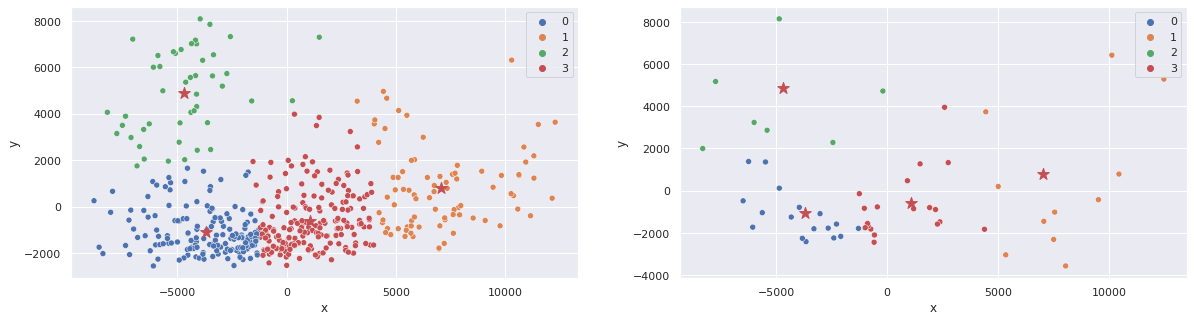

In [127]:
kmeans_2_2d = K_means(4, pd.DataFrame(train_2_2d), 20)
kmeans_2_2d.runKmeans()

pred_train_2 = kmeans_2_2d.predict(train_2_2d)
pred_test_2 = kmeans_2_2d.predict(test_2_2d)

plot_train_test_pred(pd.DataFrame(train_2_2d, columns=["x", "y"]), pd.DataFrame(test_2_2d, columns=["x", "y"]), pred_train_2, pred_test_2, kmeans_2_2d.cluster_centroids[-1])

##### Normalizado

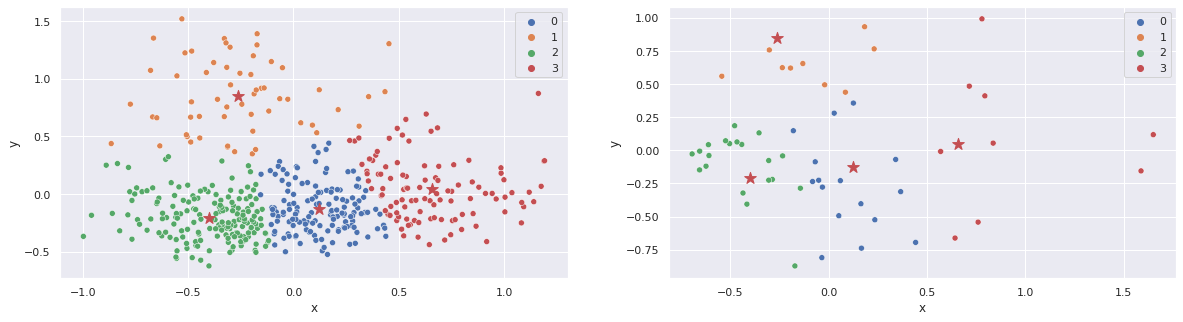

In [129]:
kmeans_2_2d_norm = K_means(4, pd.DataFrame(train_2_2d_norm), 20)
kmeans_2_2d_norm.runKmeans()

pred_train_2 = kmeans_2_2d_norm.predict(train_2_2d_norm)
pred_test_2 = kmeans_2_2d_norm.predict(test_2_2d_norm)

plot_train_test_pred(pd.DataFrame(train_2_2d_norm, columns=["x", "y"]), pd.DataFrame(test_2_2d_norm, columns=["x", "y"]), pred_train_2, pred_test_2, kmeans_2_2d_norm.cluster_centroids[-1])

#### 1 Dimensão

##### Não normalizado

In [ ]:
kmeans_2_1d = K_means(3, pd.DataFrame(train_2_1d), 20)
kmeans_2_1d.runKmeans()

pred_train_2 = kmeans_2_1d.predict(train_2_1d)
pred_test_2 = kmeans_2_1d.predict(test_2_1d)


##### Normalizado

In [ ]:
kmeans_2_1d_norm = K_means(3, pd.DataFrame(train_2_1d_norm), 20)
kmeans_2_1d_norm.runKmeans()

pred_train_2 = kmeans_2_1d_norm.predict(train_2_1d_norm)
pred_test_2 = kmeans_2_1d_norm.predict(test_2_1d_norm)

#### Métricas de avaliação dos clusters - k=4, dimensões: [3,2,1], normalizado e não normalizado

In [ ]:
clusters_metrics = clusters_metrics.append(metrics(pd.DataFrame(train_2_3d), kmeans_2_3d.predict(pd.DataFrame(train_2_3d)), kmeans_2_3d.cluster_centroids[-1], 'kmeans-3d-k4', 0 , 2, 1), ignore_index=True)
clusters_metrics = clusters_metrics.append(metrics(train_2_2d, kmeans_2_2d.predict(train_2_2d), kmeans_2_2d.cluster_centroids[-1], 'kmeans-2d-k4',0,2,1), ignore_index=True)
clusters_metrics = clusters_metrics.append(metrics(train_2_1d, kmeans_2_1d.predict(train_2_1d), kmeans_2_1d.cluster_centroids[-1], 'kmeans-1d-k4',0,2,1), ignore_index=True)
clusters_metrics = clusters_metrics.append(metrics(pd.DataFrame(train_2_3d_norm), kmeans_2_3d_norm.predict(pd.DataFrame(train_2_3d_norm)), kmeans_2_3d_norm.cluster_centroids[-1], 'kmeans-3d-k4', 1, 2, 1), ignore_index=True)
clusters_metrics = clusters_metrics.append(metrics(train_2_2d_norm, kmeans_2_2d_norm.predict(train_2_2d_norm), kmeans_2_2d_norm.cluster_centroids[-1], 'kmeans-2d-k4',1,2,1), ignore_index=True)
clusters_metrics = clusters_metrics.append(metrics(train_2_1d_norm, kmeans_2_1d_norm.predict(train_2_1d_norm), kmeans_2_1d_norm.cluster_centroids[-1], 'kmeans-1d-k4',1,2,1), ignore_index=True)


------------------------------------------------------------------------------------------------------------
### KMeans com k=5

#### 3 Dimensões

##### Não normalizado

In [ ]:
kmeans_2_3d = K_means(5, pd.DataFrame(train_2_3d), 20)
kmeans_2_3d.runKmeans()

pred_train_2 = kmeans_2_3d.predict(train_2_3d)
pred_test_2 = kmeans_2_3d.predict(test_2_3d)

##### Normalizado

In [ ]:
kmeans_2_3d_norm = K_means(4, pd.DataFrame(train_2_3d_norm), 20)
kmeans_2_3d_norm.runKmeans()

pred_train_2 = kmeans_2_3d_norm.predict(train_2_3d_norm)
pred_test_2 = kmeans_2_3d_norm.predict(test_2_3d_norm)

#### 2 Dimensões

##### Não normalizado

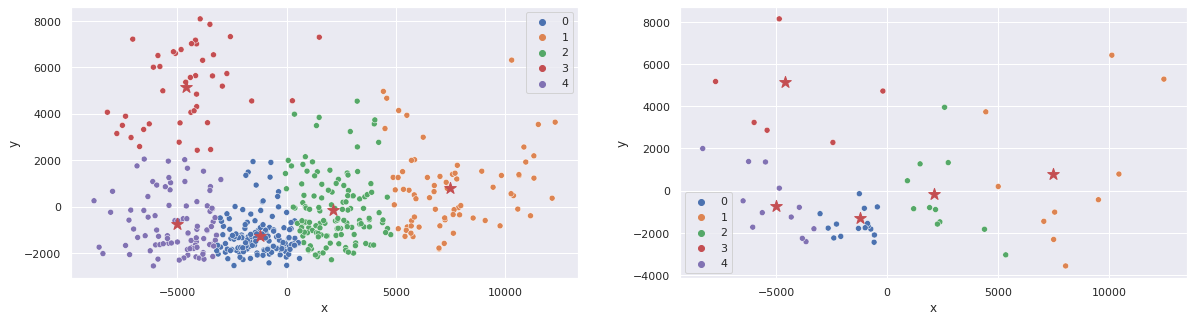

In [130]:
kmeans_2_2d = K_means(5, pd.DataFrame(train_2_2d), 20)
kmeans_2_2d.runKmeans()

pred_train_2 = kmeans_2_2d.predict(train_2_2d)
pred_test_2 = kmeans_2_2d.predict(test_2_2d)

plot_train_test_pred(pd.DataFrame(train_2_2d, columns=["x", "y"]), pd.DataFrame(test_2_2d, columns=["x", "y"]), pred_train_2, pred_test_2, kmeans_2_2d.cluster_centroids[-1])

##### Normalizado

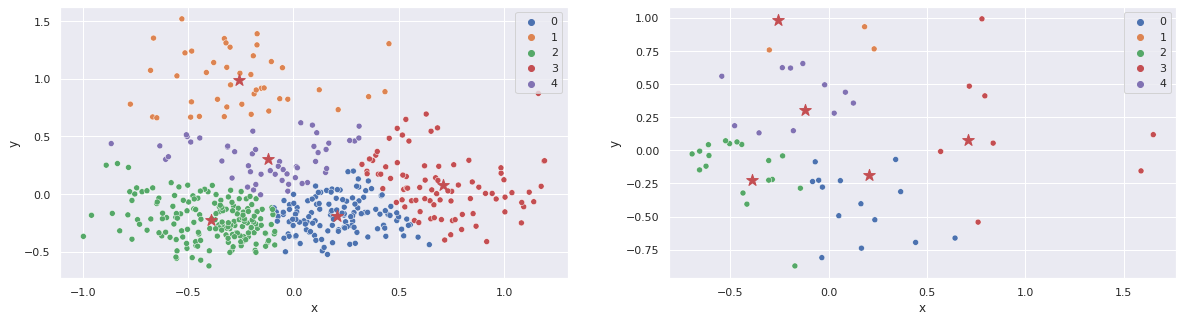

In [131]:
kmeans_2_2d_norm = K_means(5, pd.DataFrame(train_2_2d_norm), 20)
kmeans_2_2d_norm.runKmeans()

pred_train_2 = kmeans_2_2d_norm.predict(train_2_2d_norm)
pred_test_2 = kmeans_2_2d_norm.predict(test_2_2d_norm)

plot_train_test_pred(pd.DataFrame(train_2_2d_norm, columns=["x", "y"]), pd.DataFrame(test_2_2d_norm, columns=["x", "y"]), pred_train_2, pred_test_2, kmeans_2_2d_norm.cluster_centroids[-1])

#### 1 Dimensão

##### Não normalizado

In [132]:
kmeans_2_1d = K_means(5, pd.DataFrame(train_2_1d), 20)
kmeans_2_1d.runKmeans()

pred_train_2 = kmeans_2_1d.predict(train_2_1d)
pred_test_2 = kmeans_2_1d.predict(test_2_1d)


##### Normalizado

In [133]:
kmeans_2_1d_norm = K_means(5, pd.DataFrame(train_2_1d_norm), 20)
kmeans_2_1d_norm.runKmeans()

pred_train_2 = kmeans_2_1d_norm.predict(train_2_1d_norm)
pred_test_2 = kmeans_2_1d_norm.predict(test_2_1d_norm)

#### Métricas de avaliação dos clusters - k=5, dimensões: [3,2,1], normalizado e não normalizado

In [134]:
clusters_metrics = clusters_metrics.append(metrics(pd.DataFrame(train_2_3d), kmeans_2_3d.predict(pd.DataFrame(train_2_3d)), kmeans_2_3d.cluster_centroids[-1], 'kmeans-3d-k5', 0 , 2, 1), ignore_index=True)
clusters_metrics = clusters_metrics.append(metrics(train_2_2d, kmeans_2_2d.predict(train_2_2d), kmeans_2_2d.cluster_centroids[-1], 'kmeans-2d-k5',0,2,1), ignore_index=True)
clusters_metrics = clusters_metrics.append(metrics(train_2_1d, kmeans_2_1d.predict(train_2_1d), kmeans_2_1d.cluster_centroids[-1], 'kmeans-1d-k5',0,2,1), ignore_index=True)
clusters_metrics = clusters_metrics.append(metrics(pd.DataFrame(train_2_3d_norm), kmeans_2_3d_norm.predict(pd.DataFrame(train_2_3d_norm)), kmeans_2_3d_norm.cluster_centroids[-1], 'kmeans-3d-k5', 1, 2, 1), ignore_index=True)
clusters_metrics = clusters_metrics.append(metrics(train_2_2d_norm, kmeans_2_2d_norm.predict(train_2_2d_norm), kmeans_2_2d_norm.cluster_centroids[-1], 'kmeans-2d-k5',1,2,1), ignore_index=True)
clusters_metrics = clusters_metrics.append(metrics(train_2_1d_norm, kmeans_2_1d_norm.predict(train_2_1d_norm), kmeans_2_1d_norm.cluster_centroids[-1], 'kmeans-1d-k5',1,2,1), ignore_index=True)


---------------------------------------------------------------------------------------------------------------

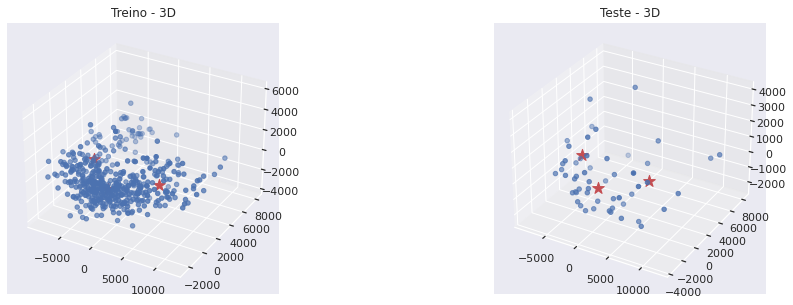

Components =  3 
Total explained variance =  0.702


In [112]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
    
centroids = kmeans_2_3d.cluster_centroids[-1]
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(train_2_3d[:, 0], train_2_3d[:,1], train_2_3d[:,2])
for c in range(len(centroids)): 
    ax.scatter(centroids[c][0], centroids[c][1], centroids[c][2], color='r', marker='*', s=150)
plt.title('Treino - 3D')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(test_2_3d[:, 0], test_2_3d[:,1], test_2_3d[:,2])
for c in range(len(centroids)): 
    ax.scatter(centroids[c][0], centroids[c][1], centroids[c][2], color='r', marker='*', s=150)
plt.title('Teste - 3D')
plt.show()

print("Components = ", pca_3.n_components_,"\nTotal explained variance = ",round(pca_3.explained_variance_ratio_.sum(),5)  )

# PLOTS

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap


fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(train_2_3d[:, 0], train_2_3d[:,1], train_2_3d[:,2])
plt.title('Treino - 3D')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(test_2_3d[:, 0], test_2_3d[:,1], test_2_3d[:,2])
plt.title('Teste - 3D')
plt.show()

print("Components = ", pca_3.n_components_,"\nTotal explained variance = ",round(pca_3.explained_variance_ratio_.sum(),5)  )

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.scatterplot(data=train_2_2d)
plt.title('Treino - 2D')

plt.subplot(1,2,2)
sns.scatterplot(data=test_2_2d)
plt.title('Teste - 2D')
plt.show()

print("Components = ", pca_2.n_components_,"\nTotal explained variance = ",round(pca_2.explained_variance_ratio_.sum(),5)  )

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.scatterplot(data=train_2_1d)
plt.title('Treino - 1D')

plt.subplot(1,2,2)
sns.scatterplot(data=test_2_1d)
plt.title('Teste - 1D')
plt.show()

print("Components = ", pca_1.n_components_,"\nTotal explained variance = ",round(pca_1.explained_variance_ratio_.sum(),5)  )

# Avaliação e Discussão

## Normalização

## Quantidade de Clusters

Para o dataset 1 -ok
Dataset 2 - clusters exagerados na vdd seriam 2 (n-Dim) analisar com menos

## Inicialização dos clusters

## Vantagens e desvantagens

### K-Means

#### Vantagens

- Possibilidade de várias alterações, ex: distâncias diferentes;
- Método simples e rápido;
- Maximiza a dispersão entre os centros dos clusters (clusters separados).

#### Desvantagens

- É necessário a escolha do número de clusters (K);
- Todos os dados são forçados a pertencer a um cluster;
- É sensível à escala dos dados;
- Pode ficar preso em mínimos locais;
- Sensível a ruído;
- Não funciona com dados discretos;


### MeanShift

#### Vantagens

- Não necessita a escolha do número de clusters, algoritmo descobre sozinho;
- Os centros do cluster convergem para os pontos de densidade máxima.

#### Desvantagens

- É necessário a escolha do raio da janela, o que pode não ser trivial.
- Custo computacional alto.



## Dimensionalidade

- Como a normalização afetou o resultado?
- A quantidade de clusters é representativo pros dados?
- A inicialização dos clusters afetou o resultado? 
- Vantagens e desvantagens de cada método
- Como a dimensionalidade afetou os resultados?

# Contribuição de cada membro

A contribuição de cada membro foi equivalente, a Bruna ficou com a parte do Mean Shift e o Vitor com a parte do K-Means, ambos geraram e analisaram seus resultados, revisaram o resultado do outro e se ajudaram.